Neural Point Process

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform
from functools import lru_cache

# Dataset and Visualization

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data_folder = "data_100images_100by100pixels_upto10pins_4seed"

In [4]:
class SynthHeatmapDataset(Dataset):
    """Synthetic Heatmaps dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pins_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pins_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.pins_frame.iloc[idx, 0])
        image = io.imread(img_name)
        pins = np.asarray(eval(self.pins_frame.iloc[idx, 1]))
        outputs = np.asarray(eval(self.pins_frame.iloc[idx, 2]))

        sample = {'image': image, 'pins': pins, 'outputs': outputs}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, pins, outputs = sample['image'], sample['pins'], sample['outputs']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'pins': torch.from_numpy(pins),
                'outputs': torch.from_numpy(outputs).to(torch.float32)}
    
# Define a custom transform to resize the image
class ResizeTo128x128(object):
    def __call__(self, sample):
        image, pins, outputs = sample['image'], sample['pins'], sample['outputs']
        
        # Resize the image to 100x100 pixels
        image = transforms.functional.resize(image, (128, 128))
        
        return {'image': image, 'pins': pins, 'outputs': outputs}

# Create a transform pipeline that includes the resizing step
transform = transforms.Compose([
    ToTensor(),         # Convert to tensor (as you were doing)
    ResizeTo128x128()  # Resize to 100x100
])

transformed_dataset = SynthHeatmapDataset(csv_file=f"{data_folder}/pins.csv",
                                          root_dir=f"{data_folder}/images/",
                                          transform=transform
                                         )

In [5]:
dataset_size = len(transformed_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    transformed_dataset, [train_size, val_size, test_size]
)

# Define batch size
batch_size = 32

def custom_collate_fn(batch):
    images = [sample['image'] for sample in batch]
    pins = [sample['pins'] for sample in batch]
    outputs = [sample['outputs'] for sample in batch]


    return {
        'image': torch.stack(images, dim=0),
        'pins': pins,
        'outputs': outputs
    }
# Create your DataLoader with the custom_collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)


In [6]:
#Check samples
# for batch in train_dataloader:
#     images = batch['image'][:, :3, :, :]  # get RGB instead of RGBA
#     pins = batch['pins']     
#     outputs = batch['outputs']  
#     # print(images.shape, len(pins), len(outputs))
#     # Your training or evaluation code here

    
# plt.imshow(images[3].permute(1, 2, 0))

# Loss function

In [7]:
def gaussian_kernel_matrix(X, Y, sigma):
    """
    Calculate the Gaussian kernel matrix between two sets of PyTorch tensors X and Y.

    Parameters:
    X (torch.Tensor): First set of tensors with shape (n, d), where n is the number of vectors and d is the dimensionality.
    Y (torch.Tensor): Second set of tensors with shape (m, d), where m is the number of vectors and d is the dimensionality.
    sigma (float): The kernel bandwidth parameter.

    Returns:
    torch.Tensor: The Gaussian kernel matrix of shape (n, m).
    """
    if X.size(1) != Y.size(1):
        raise ValueError("Input tensors must have the same dimension")

    n, m = X.size(0), Y.size(0)
    X = X.unsqueeze(1)  # Shape (n, 1, d)
    Y = Y.unsqueeze(0)  # Shape (1, m, d)

    diff = torch.norm(X - Y, dim=2)  # Pairwise Euclidean distances between vectors
    return torch.exp(- (diff ** 2) / (2 * sigma ** 2))


def pseudo_inverse(kernel_matrix, epsilon=1e-5):
    """
    Calculate the pseudo-inverse of a matrix using Singular Value Decomposition (SVD).

    Parameters:
    kernel_matrix (torch.Tensor): The matrix for which to compute the pseudo-inverse.
    epsilon (float): A small value to avoid division by zero.

    Returns:
    torch.Tensor: The pseudo-inverse of the input matrix.
    """
    U, S, V = torch.svd(kernel_matrix)
    S_inv = 1.0 / (S + epsilon)
    pseudo_inv = torch.mm(V, torch.mm(torch.diag(S_inv), U.t()))
    return pseudo_inv


class NPPLoss(nn.Module):
    def __init__(self, identity):
        super(NPPLoss, self).__init__()
        self.identity = identity
    
    @lru_cache(maxsize=None)  # Decorate the compute_kernel method with lru_cache, unlimited size
    def compute_kernel(self, pins, sigma=1.0):
        matrix_list = []
        for i in range(len(pins)):
            X = Y = pins[i].float()
            kernel_matrix = gaussian_kernel_matrix(X, Y, sigma)
            pseudo_inv_matrix = pseudo_inverse(kernel_matrix)
            matrix_list.append(pseudo_inv_matrix)
        return matrix_list
    
    def forward(self, y_true, y_pred, pins):
        loss = 0
        
        if self.identity:
            for i in range(len(y_true)):  # Fix the loop
                loss += torch.matmul((y_true[i] - y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]]).t(),  \
                                     (y_true[i] - y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]]))
        else:
            matrix_list = self.compute_kernel(tuple(pins))  # Convert 'pins' to a tuple
            for i in range(len(y_true)):  # iterate over images with different number of pins
                loss += torch.matmul((y_true[i] - y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]]).t(), \
                                     torch.matmul(matrix_list[i], y_true[i] -y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]]))

        return loss

# Neural Networks

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, num_kernels_encoder, num_kernels_decoder):
        super(Autoencoder, self).__init__()
        self.encoder = self._build_encoder(num_kernels_encoder)
        self.decoder = self._build_decoder(num_kernels_decoder, num_kernels_encoder[-1])  # Pass the last encoder channel
        
    def _build_encoder(self, num_kernels):
        layers = []
        in_channels = 3  # Initial input channel (grayscale)
        
        for out_channels in num_kernels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels
        
        return nn.Sequential(*layers)
    
    def _build_decoder(self, num_kernels, in_channels):
        layers = []
        
        for out_channels in num_kernels:
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2))
            layers.append(nn.ReLU())
            in_channels = out_channels
        
        # Add the final ConvTranspose2d layer to produce the grayscale output
        layers.append(nn.ConvTranspose2d(in_channels, 1, kernel_size=2, stride=2))
        layers.append(nn.Sigmoid())  # Apply Sigmoid activation to constrain output in [0, 1]
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Training

In [9]:
# Hyperparameters
# input_size = 128* 128  # easy to get the original size with AE
hidden_size = 64
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Create an instance of the Autoencoder
num_kernels_encoder = [32, 64, 128]  # Customize the number of kernels for the encoder
num_kernels_decoder = [64, 32]  # Customize the number of kernels for the decoder

autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder).to(device)
print(autoencoder)
# Loss function and optimizer
criterion = NPPLoss(identity=True).to(device)
# baseline_criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)


In [10]:
train_losses = []  # To track train loss for plotting
val_losses = []    # To track validation loss for plotting
val_every_epoch = 2

for epoch in range(num_epochs):
    for batch in train_dataloader:
        x_train = batch['image'][:, :3, :, :].to(device)  # get RGB instead of RGBA
        p_train = [tensor.to(device) for tensor in batch['pins']]  # put lists onto GPU
        y_train = [tensor.to(device) for tensor in batch['outputs']] 
        
        # Forward pass
        outputs = autoencoder(x_train.float())
        loss = criterion(y_train, outputs, p_train)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print train loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}')
    train_losses.append(loss.item())

    # Check validation loss every 5 epochs
    if (epoch + 1) % val_every_epoch == 0:
        val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_dataloader:
                x_val = val_batch['image'][:, :3, :, :].to(device)
                p_val = [tensor.to(device) for tensor in val_batch['pins']]
                y_val = [tensor.to(device) for tensor in val_batch['outputs']]
                
                val_outputs = autoencoder(x_val.float())
                val_loss += criterion(y_val, val_outputs, p_val).item()
        
        val_loss /= len(val_dataloader)  # Average validation loss
        print(f'Validation Loss: {val_loss:.4f}')
        val_losses.append(val_loss)



Epoch [1/10], Train Loss: 5647.3960
Epoch [2/10], Train Loss: 8989.1318
Validation Loss: 26540.5645
Epoch [3/10], Train Loss: 10189.4590
Epoch [4/10], Train Loss: 5329.7490
Validation Loss: 26444.4258
Epoch [5/10], Train Loss: 6408.6641
Epoch [6/10], Train Loss: 12728.7363
Validation Loss: 26443.3027
Epoch [7/10], Train Loss: 8322.9189
Epoch [8/10], Train Loss: 5227.6299
Validation Loss: 26441.4902
Epoch [9/10], Train Loss: 4046.6394
Epoch [10/10], Train Loss: 7412.9941
Validation Loss: 26433.5605


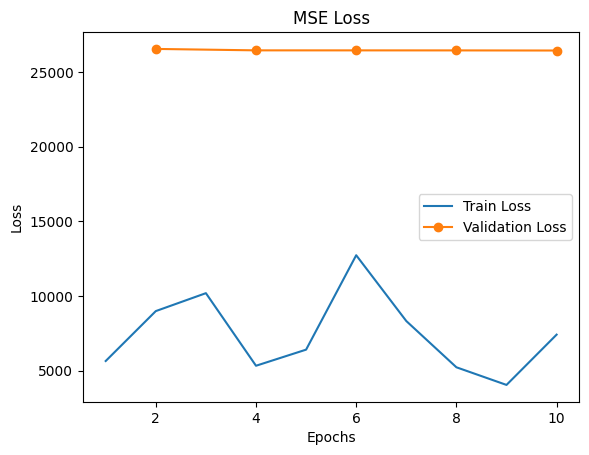

In [11]:
# Plot the train and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(val_every_epoch, num_epochs + 1, val_every_epoch), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss')
plt.legend()
plt.show()

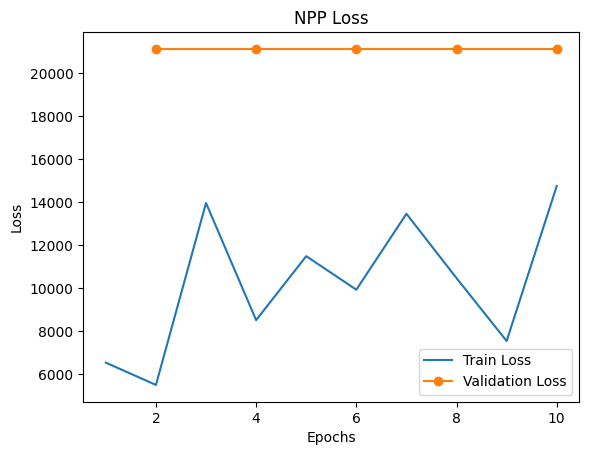

In [129]:
# Plot the train and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(val_every_epoch, num_epochs + 1, val_every_epoch), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('NPP Loss')
plt.legend()
plt.show()

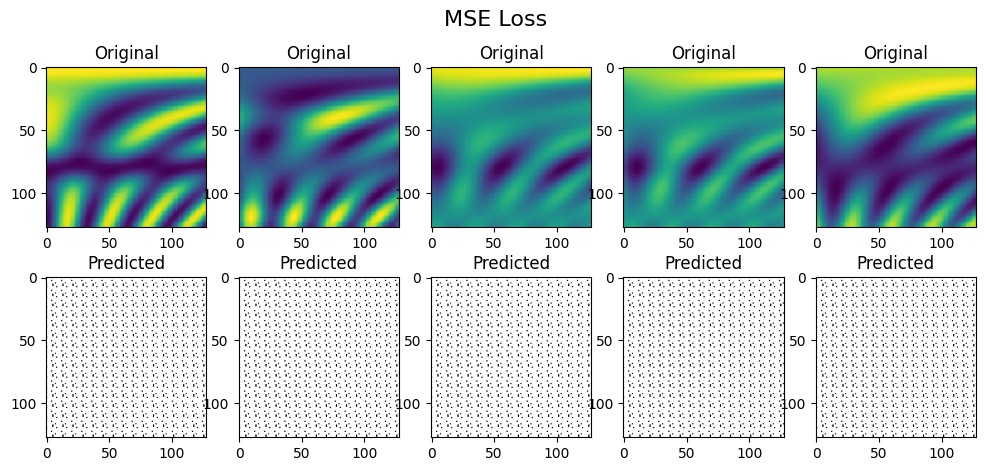

In [14]:
# Visualize original and reconstructed images
with torch.no_grad():
    for val_batch in val_dataloader:
        x_val = val_batch['image'][:, :3, :, :].to(device)
        p_val = [tensor.to(device) for tensor in val_batch['pins']]
        y_val = [tensor.to(device) for tensor in val_batch['outputs']]

        val_outputs = autoencoder(x_val.float())


plt.figure(figsize=(12, 5))
for i in range(5):
    # Original Images
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_val[i].detach().cpu().permute(1, 2, 0))
    plt.title('Original')

    # Reconstructed Images
    plt.subplot(2, 5, i + 6)
    plt.imshow(val_outputs[i].squeeze().detach().cpu(), cmap='gray')
    plt.title('Predicted')
plt.suptitle('MSE Loss', fontsize=16)
plt.show()

# Visualization

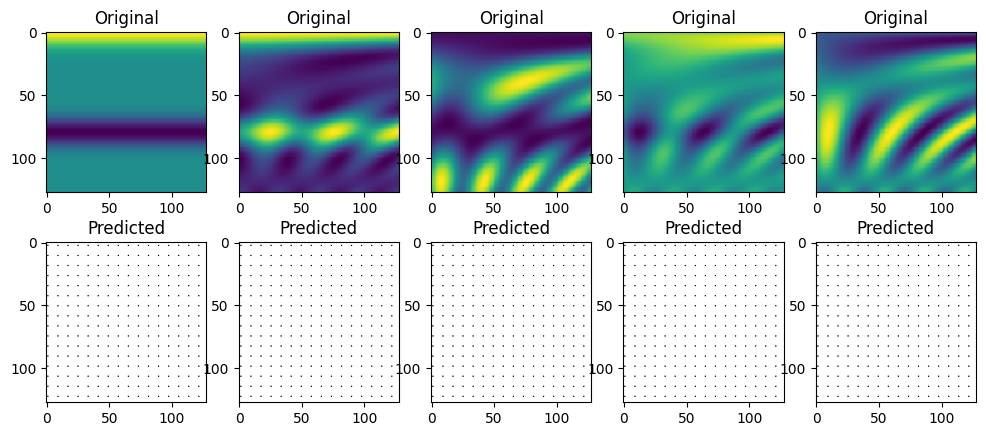

In [128]:
# Visualize original and reconstructed images
with torch.no_grad():
    for val_batch in val_dataloader:
        x_val = val_batch['image'][:, :3, :, :].to(device)
        p_val = [tensor.to(device) for tensor in val_batch['pins']]
        y_val = [tensor.to(device) for tensor in val_batch['outputs']]

        val_outputs = autoencoder(x_val.float())


plt.figure(figsize=(12, 5))
for i in range(5):
    # Original Images
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_val[i].detach().cpu().permute(1, 2, 0))
    plt.title('Original')

    # Reconstructed Images
    plt.subplot(2, 5, i + 6)
    plt.imshow(val_outputs[i].squeeze().detach().cpu(), cmap='gray')
    plt.title('Predicted')

plt.show()